In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
import pandas as pd

from py.Dataset import Dataset
from py.FileUtils import load
from py.PlotUtils import plot_roc_curve

DIR = '/home/kleinsteuber/vscode/ResizedSessions256_NoBackup' # dataset directory
SESSION = "marten_01"
TRAIN_NAME = "ae2_deep_noise_sparse_marten_01"

ds = Dataset(DIR)
session = ds.create_session(SESSION)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 2 sessions
Session 'Marten_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.


In [15]:
lapse_losses, lapse_encodings, lapse_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_lapse.pickle")
motion_losses, motion_encodings, motion_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_motion.pickle")

In [16]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(lapse_encodings)

In [17]:
preds = kde.score_samples(motion_encodings)
y_anom = preds[motion_labels == 1]
y_norm = preds[motion_labels == 0]

In [18]:
pd.Series(y_norm).describe()

count    2.510000e+02
mean    -8.112198e+07
std      7.719151e+07
min     -2.596059e+08
25%     -1.292464e+08
50%     -6.332858e+07
75%     -5.495176e+06
max      3.179783e+02
dtype: float64

In [19]:
pd.Series(y_anom).describe()

count    4.900000e+01
mean    -1.902134e+09
std      1.244863e+09
min     -4.574705e+09
25%     -1.643442e+09
50%     -1.380562e+09
75%     -1.193421e+09
max     -6.012163e+08
dtype: float64

In [24]:
mode = "kde,loss"

if mode == "kde":
    y_anom = preds[motion_labels == 1]
    y_norm = preds[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode == "loss":
    y_anom = motion_losses[motion_labels == 1]
    y_norm = motion_losses[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode == "loss,kde" or mode == "kde,loss":
    mode = "kde,loss"
    y_anom = np.array([preds[motion_labels == 1], motion_losses[motion_labels == 1]]).transpose()
    y_norm = np.array([preds[motion_labels == 0], motion_losses[motion_labels == 0]]).transpose()
    X = np.concatenate([y_norm, y_anom])
    y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
else:
    raise ValueError("unknown mode")

clf = LogisticRegression().fit(X, y)
clf.score(X, y)

0.3233333333333333

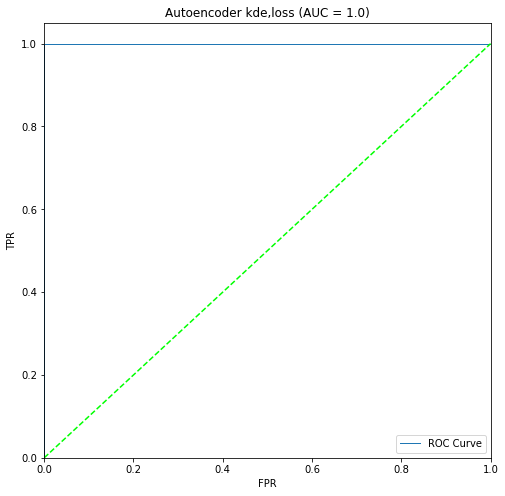

In [25]:
fpr, tpr, thresholds, auc_score = plot_roc_curve(y, clf.decision_function(X), f"Autoencoder {mode}", savefile=f"plots/approach4/roc_curves/{session.name}_{mode}")

## AUC Scores

### Beaver_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.5549 |
| KDE | 0.9209 |
| KDE + Loss | 0.9209 |

### Marten_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.8499 |
| KDE | 1.0 |
| KDE + Loss | 1.0 |